In [244]:
%load_ext autoreload
%autoreload 2

import simplemir.fileutils as fu
import simplemir.music21utils as mu
from music21 import stream, note, tempo, key, meter, clef, analysis,pitch
import pprint
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# path = 'wtcbki'
# path = 'bach/wtc'
# path = 'bach/wtc/wtcbkii'
path = 'wtc_C'

pathList = fu.get_list_files(path, extension="xml")
scoreTuppleList = mu.get_scores_from_paths_json(pathList)
for i, e in enumerate(scoreTuppleList):
    print(i, e)
#     e[1].show()
# scoreTuppleList[1][1].show()


In [ ]:
len(scoreTuppleList)
allMeasures =[]
lastMetronomeMark = tempo.MetronomeMark()
lastKeysignature = key.KeySignature()
lastTimeSignature = meter.TimeSignature()
lastClef = clef.Clef()

for i,strm in enumerate(scoreTuppleList):
    path=strm['path']
    strmScore =strm['score']
    for p in strmScore.getElementsByClass(stream.Part):
        for m in p.getElementsByClass(stream.Measure):
#             print('-----------------')
#             print(m.keySignature)
            isActive = False
#             newMeasure =stream.Measure()
#             newMeasure.append(lastMetronomeMark)
#             newMeasure.append(lastKeysignature)
#             newMeasure.append(lastTimeSignature)
            for r in m.recurse():
                if type(r) == clef.TrebleClef:
#                     print(r)
                    lastClef =r
                if type(r) == clef.BassClef:
#                     print(r)
                    lastClef =r
                if type(r) == note.Note:
                    isActive = True
                if type(r) == tempo.MetronomeMark:
                    lastMetronomeMark = r
                if type(r) == key.KeySignature:
                    lastKeysignature = r
                if type(r) == meter.TimeSignature:
                    lastTimeSignature=r
#                 r.show('txt')
#                 newMeasure.append(r)
            try:
                m.insert(0,lastTimeSignature)
                m.insert(0,lastMetronomeMark)
                m.insert(0,lastKeysignature)
                m.insert(0,lastClef)
            except:
                True
#                 print('change')
            if isActive:
#                 allMeasures.append((path,p.partName,m.number,newMeasure))
#                 allMeasures.append((path,p.partName,m.number,m))
                obj = {
                    "path":path,
                    "part":p.partName,
                    "number":m.number,
                    "measure":m
                }
                allMeasures.append(obj)

print(len(allMeasures))
for a in allMeasures:
    print(a)


In [ ]:
print(len(allMeasures))
for a in allMeasures:
    print(a)
#     a[3].show('txt')

In [81]:
len(allMeasures)
import random

random.shuffle(allMeasures)
# print ("Reshuffled list : ",  allMeasures)


In [82]:
stream2 = stream.Stream()
for i, m in enumerate(allMeasures[0:90]):
    m['measure'].number = i+1
    stream2.append(m['measure'])

    streamRes = mu.remove_breaks(stream2)
# stream2.write('xml')

streamRes.write('xml')
# streamRes.show()
streamRes.show('midi')

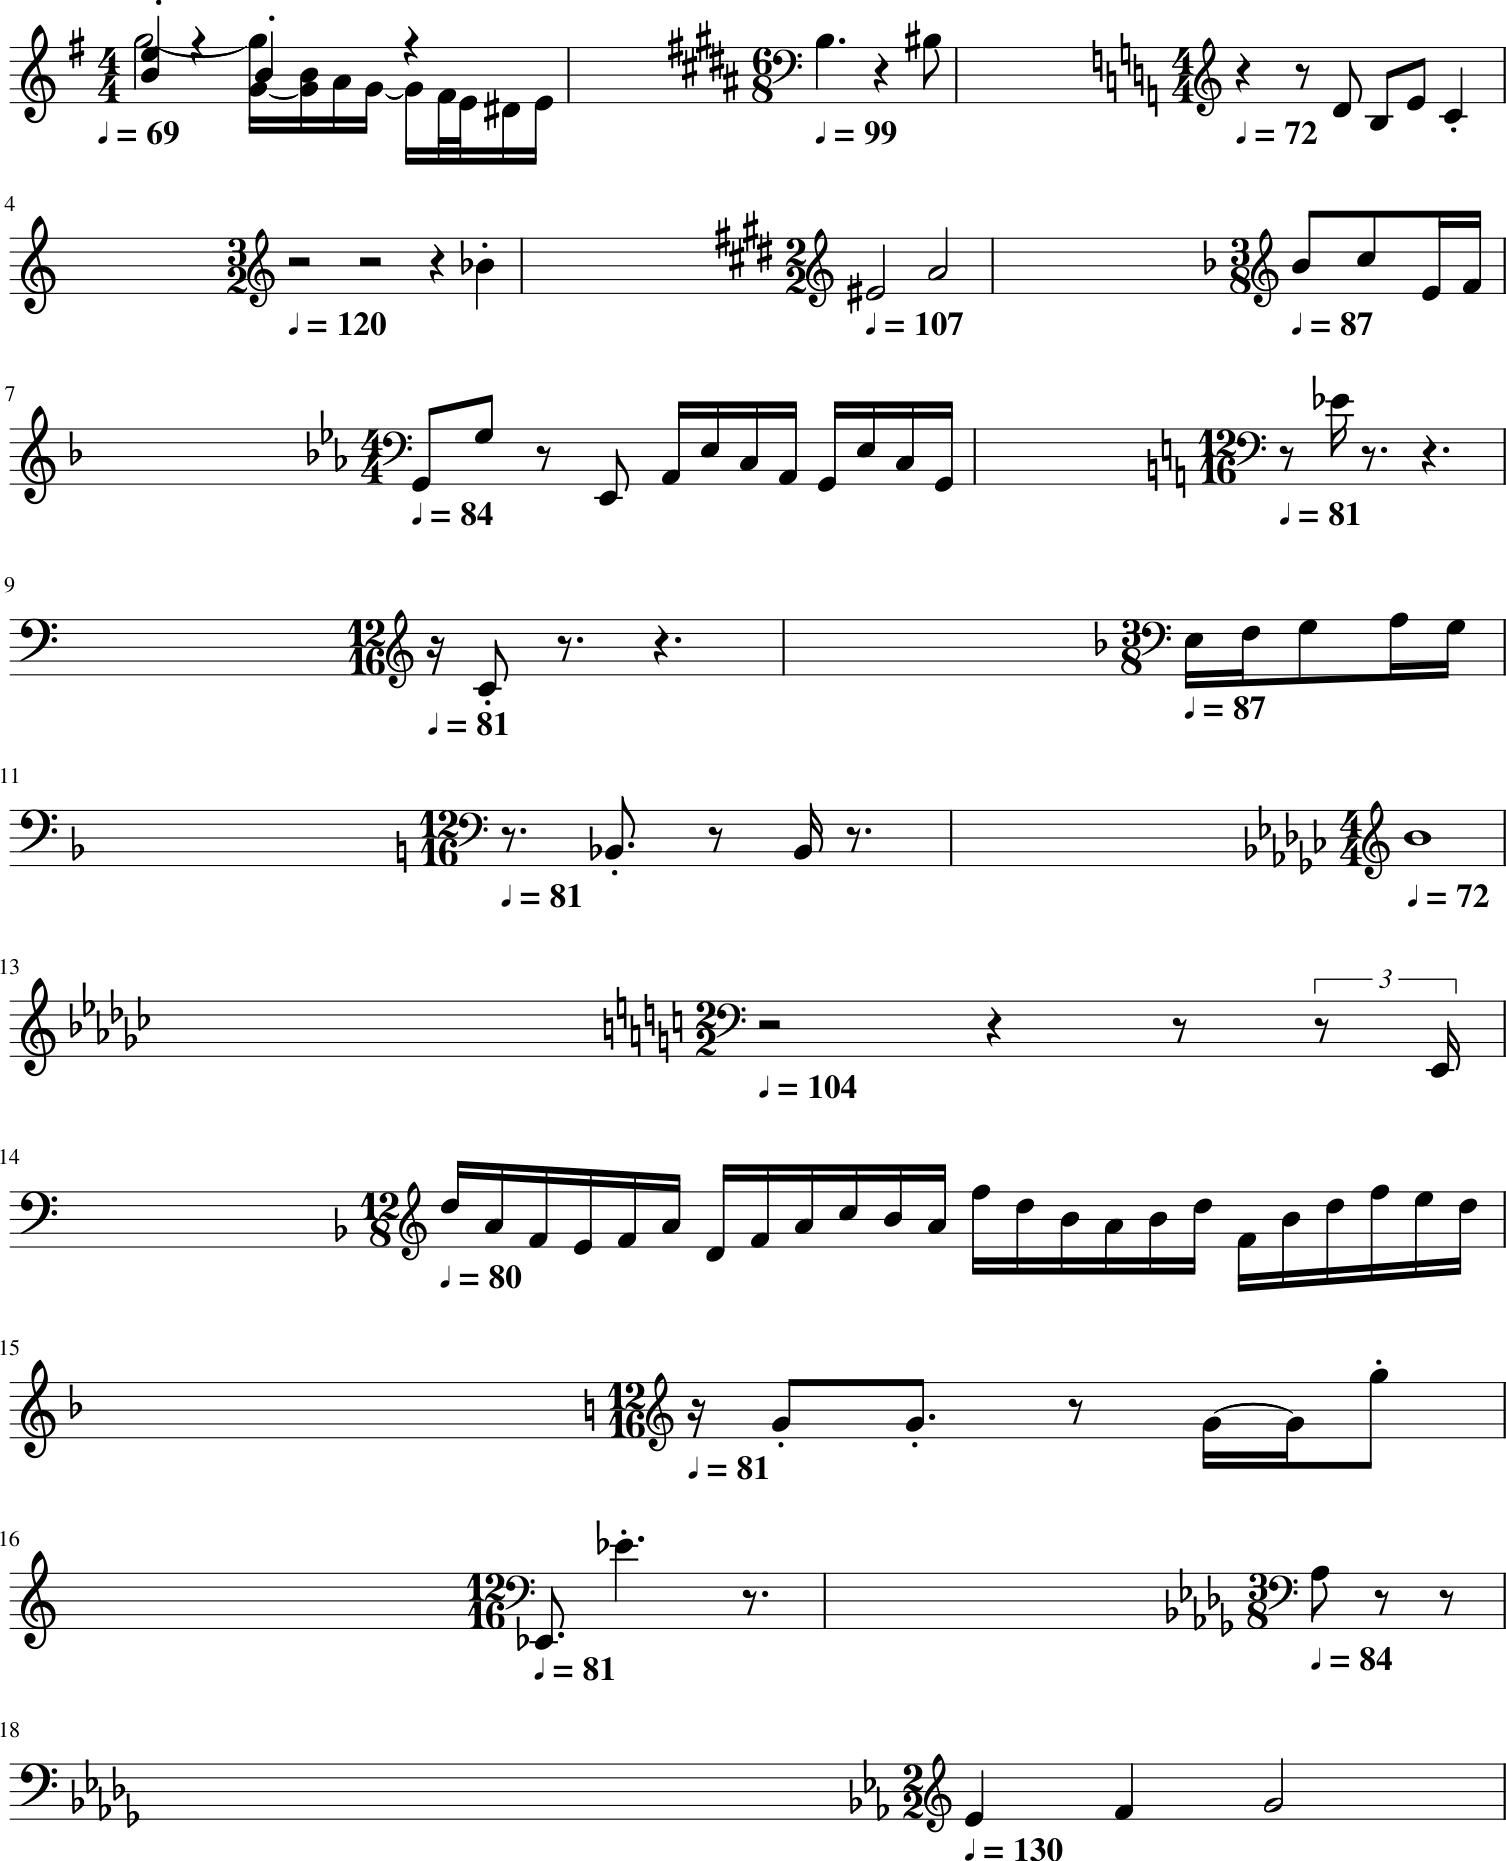

In [83]:
streamRes.show()

In [256]:
def numberNotes(strm):
    numNotes = 0
    for e in strm.recurse():
        if type(e) == note.Note:
            numNotes+=1
    return numNotes

def counterToPitchVector(count):
    ret = [0,0,0,0,0,0,0,0,0,0,0,0]
    for e in pcCount:
        ret[int(e)]=pcCount[e]
    return ret

def letterToKey(letter):
    isMayor= -1 if letter[0].islower()else  1
    pclass =pitch.Pitch(letter).pitchClass
    ret = [0,0,0,0,0,0,0,0,0,0,0,0]
    ret[pclass]=isMayor
    return ret

def melIntervalsHisto(melInters):
    ret = [0,0,0,0,0,0,0,0,0,0,0,0]
    if len(melInters.items())>0:
        for key,value in melInters.items():
#             print(key,value)
            ret[value[0].semitones%12] =value[1]
    return ret


In [ ]:
start = time.time()
p = analysis.discrete.Ambitus()

for i, m in enumerate(allMeasures):
    if i%100==0:
        print(int(time.time()-start),'sec ',(100*i)//len(allMeasures),'%')

    measStrm = m['measure']
    mel = melIntervs.countMelodicIntervals(measStrm)
    pcCount = analysis.pitchAnalysis.pitchAttributeCount(measStrm, 'pitchClass')

    descObj = {
        'numberNotes':numberNotes(measStrm),
        'key':letterToKey(measStrm.analyze('key').tonicPitchNameWithCase),
        'pitchSpan': [int(thisPitch.ps) for thisPitch in p.getPitchSpan(measStrm)],
        'pitchRanges': list(p.getPitchRanges(measStrm)),
        'melIntervs' :melIntervalsHisto(mel),
        'pcCount':counterToPitchVector(pcCount)
#         tempo, meter
        
    }
    m['descriptors']= descObj

end = time.time()
print(end - start)
    
# for d in allMeasures:
#     pprint.pprint(d)

In [ ]:
def sortNumNotes(meas): 
    return meas['descriptors']['numberNotes'] 

allMeasures.sort(key=sortNumNotes,reverse=True)
# allMeasures.sort(key=sortNumNotes,reverse=False)
for d in allMeasures:
    pprint.pprint(d)

In [ ]:
descs = [d['descriptors']['key'] for d in allMeasures]
pprint.pprint(descs)

In [278]:
from sklearn.cluster import KMeans
import numpy as np
# X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])
X = np.array(descs)

kmeans = KMeans(n_clusters=100, random_state=0).fit(X)
# kmeans.predict([[0, 0], [12, 3]])
# kmeans.cluster_centers_


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return_n_iter=True)


In [ ]:
print(len(descs),len(kmeans.labels_))
res =zip(kmeans.labels_,descs)
for i, r in enumerate(res):
    print(i,r)


## PitchRange
For a given subStream, return the smallest .ps difference between any two pitches and the largest difference between any two pitches. This is used to get the smallest and largest ambitus possible in a given work.

## PitchSpan
For a given subStream, return the pitch with the minimum and maximum pitch space value found.

## MelodicIntervalDiversity.countMelodicIntervals()
An analysis method to determine the diversity of intervals used in a Stream.

## Melodic variability
Ggives the Melodic Interval Variability (MIV) for a Stream, as defined by Aniruddh D. Patel in “Music, Language, and the Brain” p. 223, as 100 x the coefficient of variation (standard deviation/mean) of the interval size (measured in semitones) between consecutive elements.

the 100x is designed to put it in the same range as nPVI

this method takes the same arguments of skipArgs and skipKeywords as Stream.melodicIntervals() for determining how to find consecutive intervals.

## nPVI

Algorithm to give the normalized pairwise variability index (Low, Grabe, & Nolan, 2000) of the rhythm of a stream.

Used by Aniruddh D. Patel to argue for national differences between musical themes. First encountered it in a presentation by Patel, Chew, Francois, and Child at MIT.

n.b. – takes the distance between each element, including clefs, keys, etc. use .notesAndRests etc. to filter out elements that are not useful (though this will skip zero length objects)

n.b. # 2 – duration is used rather than actual distance – for gapless streams (the norm) these two measures will be identical.

## pitchAttributeCount(s, pitchAttr='name')
Return a collections.Counter of pitch class usage (count) by selecting an attribute of the Pitch object.


In [230]:
def counterToPitchVector(count):
    ret = [0,0,0,0,0,0,0,0,0,0,0,0]
    for e in pcCount:
        ret[int(e)]=pcCount[e]
    return ret
def letterToKey(letter):
    isMayor= -1 if letter[0].islower()else  1
    pclass =pitch.Pitch(letter).pitchClass
    ret = [0,0,0,0,0,0,0,0,0,0,0,0]
    ret[pclass]=isMayor
    print(ret)
def melIntervalsHisto(melInters):
    ret = [0,0,0,0,0,0,0,0,0,0,0,0]
    for key,value in melInters.items():
        ret[value[0].semitones] =value[1]
    return ret

letterToKey('b')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]


In [235]:
m= allMeasures[100]['measure']
# m.show()
p = analysis.discrete.Ambitus()
pitchSpan =[int(thisPitch.ps) for thisPitch in p.getPitchSpan(m)]
pitchRanges = p.getPitchRanges(m)
melIntervs =analysis.discrete.MelodicIntervalDiversity()
mel = melIntervs.countMelodicIntervals(m)
# melVar= analysis.patel.melodicIntervalVariability(m) # need at leat 3 notes
pcCount = analysis.pitchAnalysis.pitchAttributeCount(m, 'pitchClass')

# npvi= analysis.patel.nPVI(m) # need at least 3 notes
print(pitchSpan)
print(list(pitchRanges))
# print(mel)
print(melIntervalsHisto(mel))
# print(melVar)
# print(npvi)
# print(pcCount)
print(counterToPitchVector(pcCount))
# m.show()

[54, 70]
[0, 16]
[0, 0, 0, 1, 3, 3, 0, 0, 1, 0, 0, 0]
[3, 0, 3, 2, 0, 0, 2, 3, 0, 3, 4, 0]


In [219]:
len(allMeasures)

19278

In [97]:
streamRes = stream.Stream()
partPiano = stream.Part()
for i, m in enumerate(allMeasures[3000:3090]):
    m['measure'].number = i+1
    partPiano.append(m['measure'])

partViolin=stream.Part()
for i, m in enumerate(allMeasures[1000:1090]):
    m['measure'].number = i+1
    partViolin.append(m['measure'])

partCello=stream.Part()
for i, m in enumerate(allMeasures[9000:9090]):
    m['measure'].number = i+1
    partCello.append(m['measure'])
    
streamRes.append(partPiano)
streamRes.append(partViolin)
streamRes.append(partCello)
streamRes = mu.remove_breaks(streamRes)


streamRes.write('xml')
# streamRes.show()
streamRes.show('midi')

In [99]:
streamRes.write('xml')


'/tmp/music21/tmp_kgngx_k.xml'

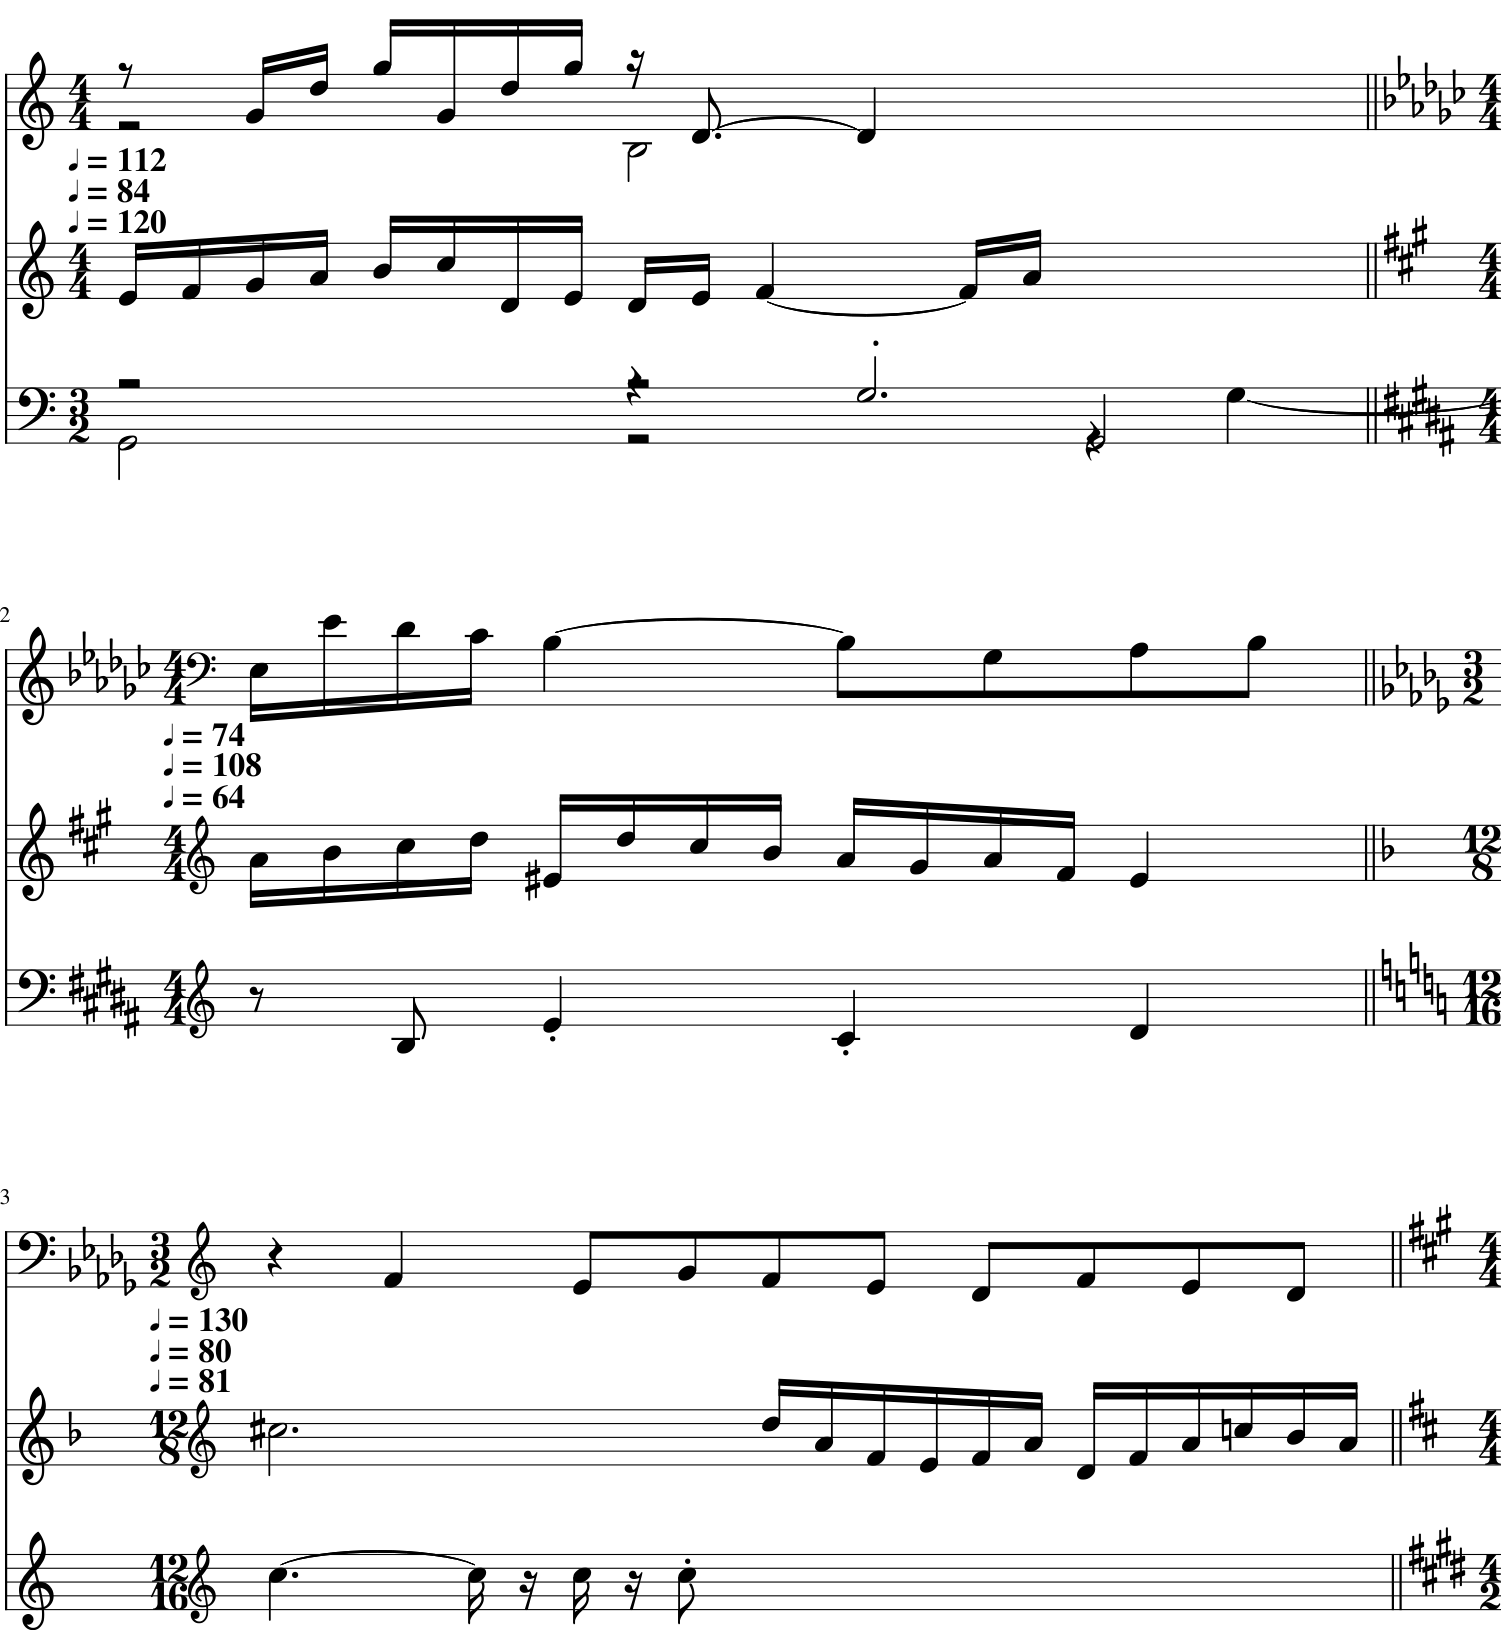

In [100]:
streamRes.show()
